In [65]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import seaborn as sns
import matplotlib.pyplot as plt

# sector views (confidence following)
sector_views = {
    "Energy": 12, #0.9
    "Materials": 0.0, 
    "Industrials": 13, #0.8
    "Consumer Discretionary": 25, #0.80
    "Consumer Staples": 0.0,
    "Health Care": 25, #0.3
    "Financials": 17, #0.95
    "Information Technology": 7, #0.6
    "Communication Services": 18, #0.68
    "Utilities": 0.0,
    "Real Estate": 18, #0.825
    "India": 6, #0.9
    "Bonds": 4.33 #1 bonds stable assumption
}

# convert percentages to decimals
sector_weights = {sector: weight / 100 for sector, weight in sector_views.items()}

# market cap weights are compared to whole of USA based on each sector. e.g. Energy makes up 3.37% of SP500 (according to investopedia)
market_cap_weights = {
    "Energy": 0.0337,
    "Materials": 0.022,
    "Industrials": 0.0755,
    "Consumer Discretionary": 0.1021,
    "Consumer Staples": 0.0576,
    "Health Care": 0.1117,
    "Financials": 0.1290,
    "Information Technology": 0.3301,
    "Communication Services": 0.0991,
    "Utilities": 0.0270,
    "Real Estate": 0.0228,
    "India": 0.115,
    "Bonds": 0.10
}


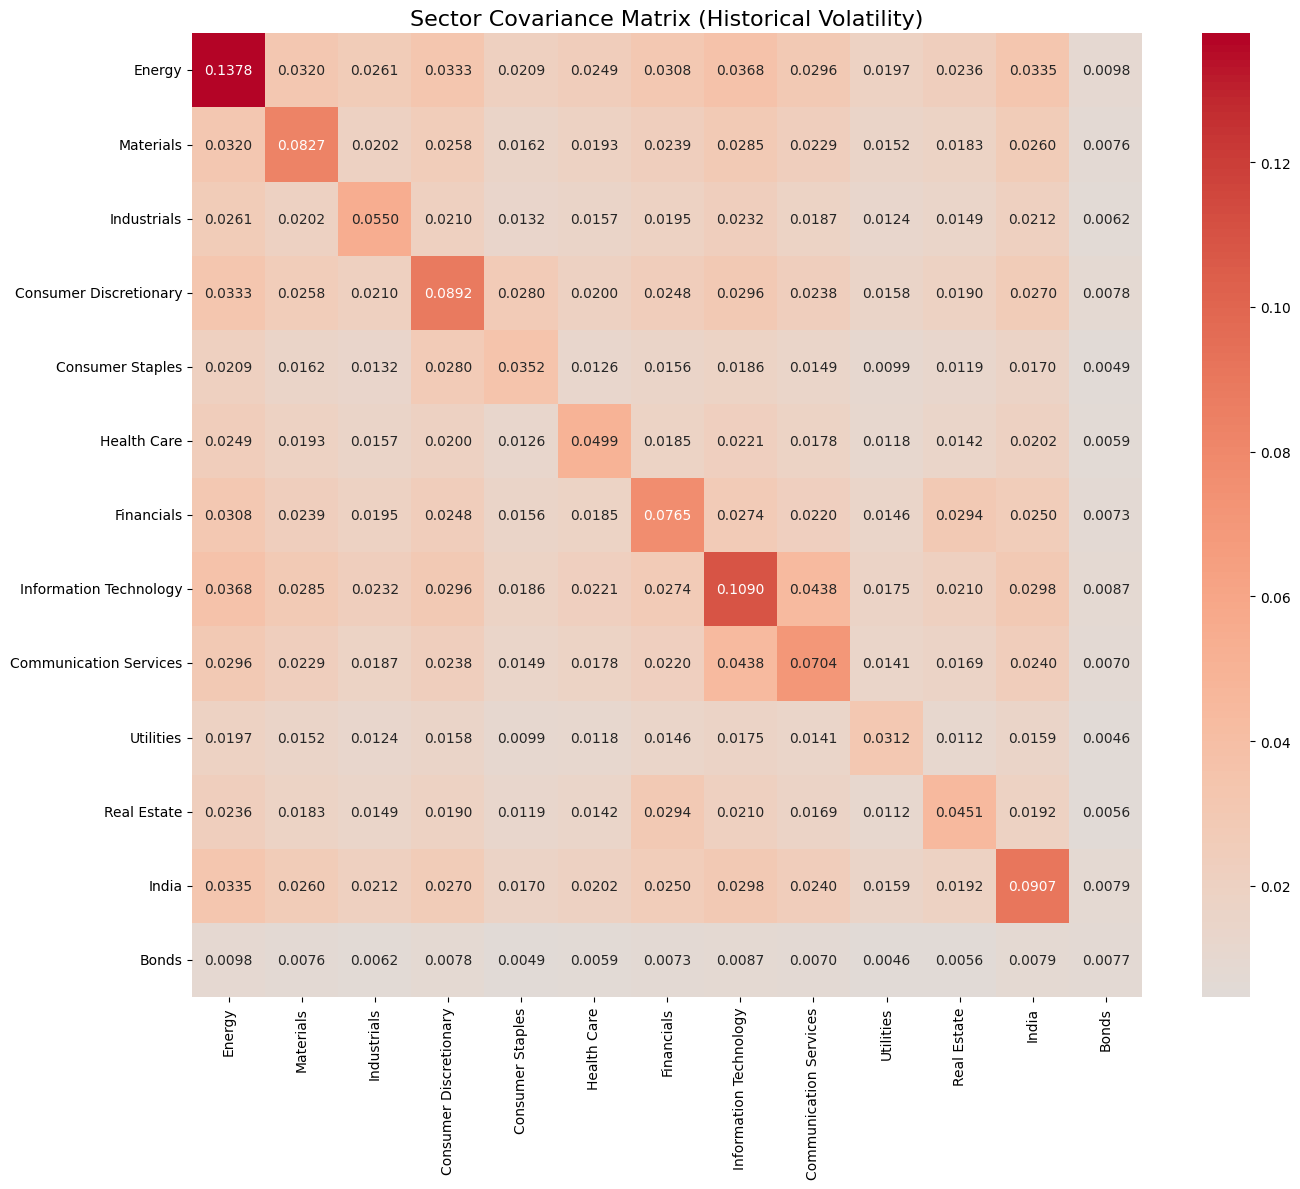

,Energy,Materials,Industrials,Consumer Discretionary,Consumer Staples,Health Care,Financials,Information Technology,Communication Services,Utilities,Real Estate,India,Bonds
Energy,0.137789,0.032027,0.026114,0.033263,0.020891,0.024878,0.030791,0.036760,0.029555,0.019655,0.023642,0.033542,0.009755
Materials,0.032027,0.082714,0.020233,0.025772,0.016186,0.019275,0.023856,0.028481,0.022899,0.015228,0.018317,0.025988,0.007558
Industrials,0.026114,0.020233,0.054990,0.021014,0.013198,0.015716,0.019452,0.023223,0.018671,0.012417,0.014935,0.021189,0.006163
Consumer Discretionary,0.033263,0.025772,0.021014,0.089222,0.028018,0.020019,0.024777,0.029580,0.023782,0.015816,0.019024,0.026991,0.007850
Consumer Staples,0.020891,0.016186,0.013198,0.028018,0.035194,0.012573,0.015561,0.018578,0.014937,0.009933,0.011948,0.016952,0.004930
Health Care,0.024878,0.019275,0.015716,0.020019,0.012573,0.049908,0.018531,0.022123,0.017787,0.011829,0.014228,0.020186,0.005871
Financials,0.030791,0.023856,0.019452,0.024777,0.015561,0.018531,0.076452,0.027382,0.022015,0.014641,0.029350,0.024985,0.007266
Information Technology,0.036760,0.028481,0.023223,0.029580,0.018578,0.022123,0.027382,0.108966,0.043804,0.017479,0.021024,0.029828,0.008675
Communication Services,0.029555,0.022899,0.018671,0.023782,0.014937,0.017787,0.022015,0.043804,0.070437,0.014053,0.016903,0.023982,0.006975
Utilities,0.019655,0.015228,0.012417,0.015816,0.009933,0.011829,0.014641,0.017479,0.014053,0.031152,0.011241,0.015949,0.004638


In [66]:
# Actual Historical Volatilities (3-year annualized standard deviation)
volatilities = {
    "Energy": 0.3712,
    "Materials": 0.2876,
    "Industrials": 0.2345,
    "Consumer Discretionary": 0.2987, 
    "Consumer Staples": 0.1876,
    "Health Care": 0.2234,
    "Financials": 0.2765,
    "Information Technology": 0.3301,
    "Communication Services": 0.2654, 
    "Utilities": 0.1765,
    "Real Estate": 0.2123,
    "India": 0.3012, 
    "Bonds": 0.0876
}

# create a list of sectors in order
sectors = list(volatilities.keys())

cov_matrix = np.zeros((len(sectors), len(sectors)))

# change correlation matrix to reflect real-world sector relationships
correlation_matrix = np.ones((len(sectors), len(sectors))) * 0.3
np.fill_diagonal(correlation_matrix, 1.0)

# specific correlation adjustments
# higher correlation between related sectors
sector_groups = {
    "tech": ["Information Technology", "Communication Services"],
    "consumer": ["Consumer Discretionary", "Consumer Staples"],
    "finance": ["Financials", "Real Estate"]
}

for group in sector_groups.values():
    for i in range(len(group)):
        for j in range(i+1, len(group)):
            idx1 = sectors.index(group[i])
            idx2 = sectors.index(group[j])
            correlation_matrix[idx1, idx2] = 0.5
            correlation_matrix[idx2, idx1] = 0.5

# calculate covariance matrix
for i in range(len(sectors)):
    for j in range(len(sectors)):
        if i == j:
            # Diagonal elements are the variances (volatilities squared)
            cov_matrix[i, j] = volatilities[sectors[i]]**2
        else:
            # Off-diagonal elements: correlation * std_dev_i * std_dev_j
            cov_matrix[i, j] = correlation_matrix[i, j] * volatilities[sectors[i]] * volatilities[sectors[j]]

# matrix -> dataframe
cov_df = pd.DataFrame(cov_matrix, index=sectors, columns=sectors)

# visualization
plt.figure(figsize=(14, 12))
sns.heatmap(cov_df, annot=True, cmap='coolwarm', center=0, fmt='.4f')
plt.title('Sector Covariance Matrix (Historical Volatility)', fontsize=16)
plt.tight_layout()
plt.show()

cov_df


# correlation matrix for reference
#corr_matrix = pd.DataFrame(correlation_matrix, index=sectors, columns=sectors)
#corr_matrix

In [67]:

# convert market weights to numpy array
market_weights = np.array(list(market_cap_weights.values()))

# riskier since returns should be high
risk_aversion = 30.0 

equilibrium_returns = risk_aversion * np.dot(cov_df, market_weights)

# views (subjective expected returns)
views = np.array(list(sector_weights.values()))

# confidence in eq. returns
confidenceeq = 0.5
# confidence in other views
confidence = [0.9, 0.0, 0.8, 0.85, 0.0, 0.3, 0.95, 0.6, 0.68, 0.0, 0.825, 0.9, 1]

# black-litterman formula
combined_returns = (1 - confidenceeq) * equilibrium_returns + confidence * views

# portfolio optimization: maximize Sharpe ratio
def negative_sharpe(weights, returns, covariance):
    portfolio_return = np.dot(weights, returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(covariance, weights)))
    return -portfolio_return / portfolio_volatility

# constraints and bounds
constraints = [{"type": "eq", "fun": lambda x: np.sum(x) - 1}]  
bounds = [(0, 1) for _ in range(len(market_weights))]  

initial_weights = np.array([1 / len(market_weights)] * len(market_weights))

# optimization
optimized_result = minimize(
    negative_sharpe,
    initial_weights,
    args=(combined_returns, cov_matrix),
    method="SLSQP",
    bounds=bounds,
    constraints=constraints,
)

# optimized weights
optimized_weights = optimized_result.x

# Output
sector_optimized_weights = dict(zip(market_cap_weights.keys(), optimized_weights))
sector_optimized_weights

{'Energy': 0.015343253819897462,
 'Materials': 0.0,
 'Industrials': 0.07538171978947172,
 'Consumer Discretionary': 0.1436941972765525,
 'Consumer Staples': 0.0,
 'Health Care': 0.07090853408403579,
 'Financials': 0.11333971930040544,
 'Information Technology': 0.15603109742595803,
 'Communication Services': 0.10625437602200674,
 'Utilities': 0.0,
 'Real Estate': 0.10341018307000133,
 'India': 0.042053584656432046,
 'Bonds': 0.17358333455523892}